---
title: Finding the Perfect Predictors
author: Anweshan Adhikari
image: "image.jpg"
description: "Maximizing Penguin Classification Accuracy with Minimal Features"
format: html
order: 6
---



# Introduction to the Data Set
The Palmer's Penguin dataset collected by  Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, includes physical measurements of individuals from three different penguin species: Chinstram, Gentoo and Adelie. Some of the features in  included culmen length, culmen depth, mass body, flipper length and so on. In this blog posts, we will try to find a group of three features that will achieve maximum accuracy for linear regression,  K-nearest Neighbour Classifier, Random Forest Classifier and decision tree classifiers. 

Before we get into finding the features, let's start by exploring our dataset. The table shown below shows the glimpse of our data.


In [11]:
import pandas as pd

train_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

train.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,27,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N46A1,Yes,11/29/07,44.5,14.3,216.0,4100.0,NaN,7.96621,-25.69327,NaN
1,PAL0708,22,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N41A2,Yes,11/27/07,45.1,14.5,215.0,5000.0,FEMALE,7.63220,-25.46569,NaN
2,PAL0910,124,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N67A2,Yes,11/16/09,41.4,18.5,202.0,3875.0,MALE,9.59462,-25.42621,NaN
3,PAL0910,146,Adelie Penguin (Pygoscelis adeliae),Anvers,Dream,"Adult, 1 Egg Stage",N82A2,Yes,11/16/09,39.0,18.7,185.0,3650.0,MALE,9.22033,-26.03442,NaN
4,PAL0708,24,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N85A2,No,11/28/07,50.6,19.4,193.0,3800.0,MALE,9.28153,-24.97134,NaN


Continuing the exploration, the graph below shows the distribution of Culmen Lengths for each penguin species

<AxesSubplot: xlabel='Culmen Length (mm)', ylabel='Count'>

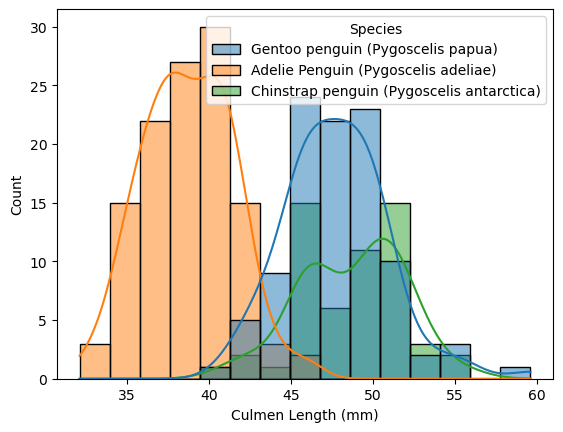

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of Culmen Lengths for each penguin species
sns.histplot(data=train, x="Culmen Length (mm)", hue="Species", kde=True, bins=15)

The histogram plot shows the distribution of culmen length for three different Penguins’ species: Adelie, Chinstrap, and Gentoo. The x-axis represents the culmen length values, and the y-axis represents the count of penguins falling into each bin, where each bin size is specified to 15. From the plot, we can see that Gentoo and Chinstrap penguins have a similar distribution of culmen length, with a peak around 45-50 mm, while Gentoo penguins have smaller culmen length, ranging from around 30mm-46mm with a peak around 40 mm. The histogram also shows the shape of the data distribution for each penguin species, with overlaid smooth curves that represent the density estimate. This helps to identify any overlapping areas or differences in the tails of the distributions. Based on the culmen lengths, it would be possible to distinguish between Adelie Penguins from the other two species with a high accuracy. However, the accuracy would be minimal in distinguishing between Chinstrap Penguin and Gentoo Penguin based on their culmen range, as both species have similar culmen lengths.

Similarly, the table offers a convenient way to compare the physical attributes of the penguin species.

In [13]:
penguin_stats = train.groupby("Species").aggregate({"Body Mass (g)": "mean", "Flipper Length (mm)": "mean"}) #Finiding the mean of body mass and flipper length for each species.
penguin_stats = penguin_stats.round(0) # Rounding the values to zero decimal place
penguin_stats.columns = ["Avg. Body Mass (g)", "Avg. Flipper Length (mm)"] # Renaming the columns 

print(penguin_stats)

                                           Avg. Body Mass (g)  \
Species                                                         
Adelie Penguin (Pygoscelis adeliae)                    3667.0   
Chinstrap penguin (Pygoscelis antarctica)              3718.0   
Gentoo penguin (Pygoscelis papua)                      5120.0   

                                           Avg. Flipper Length (mm)  
Species                                                              
Adelie Penguin (Pygoscelis adeliae)                           190.0  
Chinstrap penguin (Pygoscelis antarctica)                     195.0  
Gentoo penguin (Pygoscelis papua)                             218.0  


Based on the average measurements, the Adelie penguins have a smaller body mass and shorter flipper length compared to the other species. In contrast, the Gentoo penguins have the largest values for both of these features. The Chinstrap penguin, however, falls somewhere in the middle of the other two species. The table can serve as reference values to determine the species of an individual penguin based on their physical characteristics. For example, if a penguin has a body mass and flipper length that are close to the average measurements for a particular species, it is likely that the penguin belongs to that species.

# Data Cleaning and Preparation
Below, the Palmer's penguin dataset is being prepared to serve as the training set for the machine learning models. The code drops irrelevant columns in the dataset, removes rows with missing values, converts target variable, species, into numbers and scales the quantitative features.

In [14]:
import itertools
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
    # Drop irrelevant columns
    df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis=1)
    # Remove rows with missing values and unknown sex
    df = df[df["Sex"] != "."]
    df = df.dropna()
    # Encode the target variable
    y = le.transform(df["Species"])
    df = df.drop(["Species"], axis=1)
    # One-hot encode categorical features
    df = pd.get_dummies(df)
    # Scale the quantitative features
    scaler = StandardScaler()
    quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']
    df[quant_cols] = scaler.fit_transform(df[quant_cols])
    return df, y

X_train, y_train = prepare_data(train)


In [15]:
import warnings
from itertools import combinations
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore")

all_qual_cols = ['Island', 'Clutch Completion', 'Sex']
all_quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']

best_score_LR = 0
best_score_KNN=0
best_score_RF = 0
best_score_DT = 0

for qual in all_qual_cols:
    qual_cols = [col for col in X_train.columns if qual in col]
    for pair in combinations(all_quant_cols, 2):
        cols = list(pair) + qual_cols
        
        # Training on Logistic Regression
        LR = LogisticRegression()
        LR.fit(X_train[cols], y_train)
        lr_score = LR.score(X_train[cols], y_train)

        # Updating the best score and columns for Logistic Regression
        if lr_score > best_score_LR:
            best_cols_LR = cols
            best_score_LR = lr_score
            best_LR = LR

        # Training on K-nearest Neighbour Classifier
        KNN = KNeighborsClassifier()
        KNN.fit(X_train[cols], y_train)
        knn_score = KNN.score(X_train[cols], y_train)

        # Updating the best score and columns for k-Nearest Neighbors Classifier
        if knn_score > best_score_KNN:
            best_cols_KNN = cols
            best_score_KNN = knn_score
            best_KNN = KNN
        
        # Training on Random Forest Classifier
        RF = RandomForestClassifier(max_depth=3, random_state=0)
        RF.fit(X_train[cols], y_train)
        rf_score = RF.score(X_train[cols], y_train)

        # Updating the best score and columns for Random Forest Classifier
        if rf_score > best_score_RF:
            best_cols_RF = cols
            best_score_RF = rf_score
            best_RF = RF

        # Training on Decision Tree Classifier
        DT = DecisionTreeClassifier(max_depth=3)
        DT.fit(X_train[cols], y_train)
        dt_score = DT.score(X_train[cols], y_train)

        # Updating the best score and columns for Decision Tree Classifier
        if dt_score > best_score_DT:
            best_cols_DT = cols
            best_score_DT = dt_score
            best_DT = DT

print("Best 3 columns for LR: " + str(best_cols_LR))
print("Best 3 columns for KNN: " + str(best_cols_KNN))
print("Best 3 columns for RF: " + str(best_cols_RF))
print("Best 3 columns for DT: " + str(best_cols_DT))



Best 3 columns for LR: ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']
Best 3 columns for KNN: ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex_FEMALE', 'Sex_MALE']
Best 3 columns for RF: ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']
Best 3 columns for DT: ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']


In this section, I used four Sckit learn's machine learning models- logistic regression, k-nearest neighbor, random forest, and decision tree classifiers- to find the 3 combination of features that resulted in the highest accuracy scores. The accuracy of each combination of three features was then compared to find the combination that resulted in the highest accuracy score. 

In [16]:
# Prepare the test data
test_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/test.csv"


test = pd.read_csv(test_url)
X_test, y_test = prepare_data(test)

# Evaluate the performance of each model on the test data
test_score_LR =  best_LR.score(X_test[best_cols_LR], y_test)
test_score_KNN = best_KNN.score(X_test[best_cols_KNN], y_test)
test_score_RF = best_RF.score(X_test[best_cols_RF], y_test)
test_score_DT = best_DT.score(X_test[best_cols_DT], y_test)

# Print the test scores
print("Test score for LR: " + str(test_score_LR))
print("Test score for KNN: " + str(test_score_KNN))
print("Test score for RF: " + str(test_score_RF))
print("Test score for DT: " + str(test_score_DT))

Test score for LR: 0.9852941176470589
Test score for KNN: 0.9705882352941176
Test score for RF: 0.9705882352941176
Test score for DT: 0.9852941176470589


Our trained models were not able to achieve a 100% accuracy score in the test data. However, we identify that Logistic regression and decision tree yeild the best accuracy scored on classifying penguins. MOving forwards we will consider both Logistic regression and decision tree to be the best model for classifying penguins

In [17]:
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

      

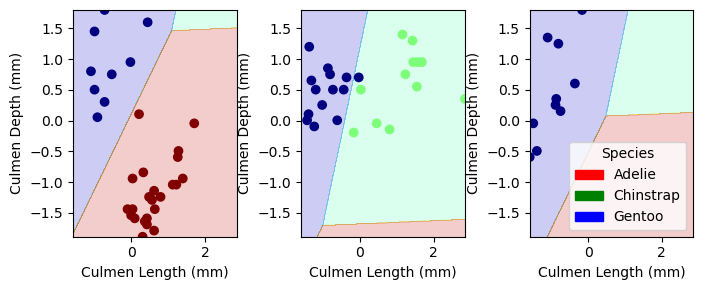

In [18]:

plot_regions(best_LR, X_test[best_cols_LR], y_test)

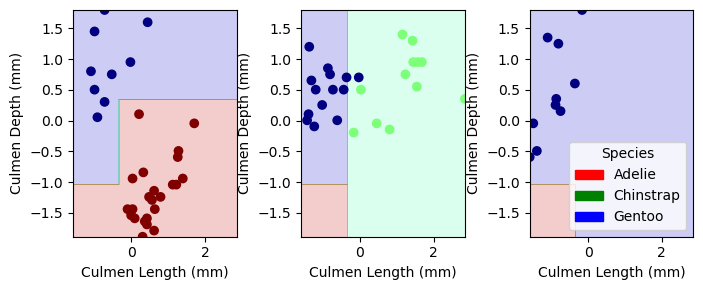

In [19]:
plot_regions(best_DT, X_test[best_cols_DT], y_test)

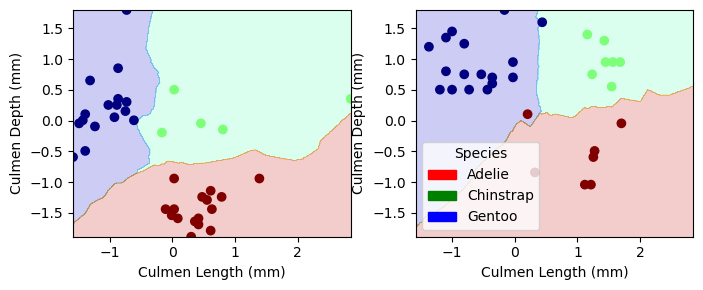

In [20]:
plot_regions(best_KNN, X_test[best_cols_KNN], y_test)

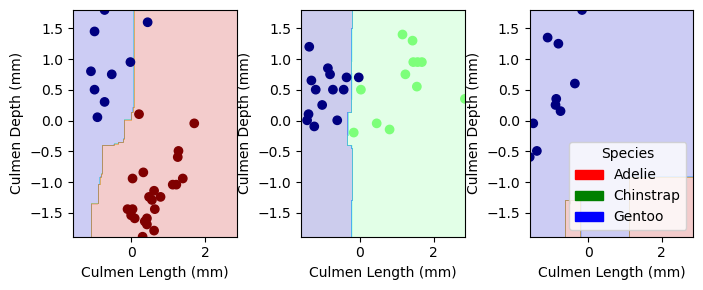

In [21]:
plot_regions(best_RF, X_test[best_cols_RF], y_test)